In [7]:
import numpy as np
from scipy.io import loadmat
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import os
import seaborn as sns

In [10]:
def load_and_combine(mat_files):
    X_combined, Y_combined = [], []
    for file in mat_files:
        data = loadmat(file)
        X = data['X_4d']  # 确保变量名与.mat文件中的一致
        Y = data['Y_2d']  # 如果维度是(4, n_samples)，需转置为X.T
        X_combined.append(X)
        Y_combined.append(Y)
    return np.vstack(X_combined), np.vstack(Y_combined)

folder = "data_new"
with os.scandir(folder) as entries:
    mat_files = [entry.path for entry in entries if entry.name.endswith('.mat') and entry.is_file()]
X, Y = load_and_combine(mat_files)
x_scalers = [MinMaxScaler() for _ in range(4)] # 对四个维度分别 MinMaxScaler
y_scalers = [MinMaxScaler() for _ in range(2)] # 对两个维度分别 MinMaxScaler
X_scaled = np.zeros(X.shape)
Y_scaled = np.zeros(Y.shape)
for i in range(4):
    X_scaled[:, i] = x_scalers[i].fit_transform(X[:, i].reshape(-1, 1)).flatten()
for i in range(2):
    Y_scaled[:, i] = y_scalers[i].fit_transform(Y[:, i].reshape(-1, 1)).flatten()

可视化

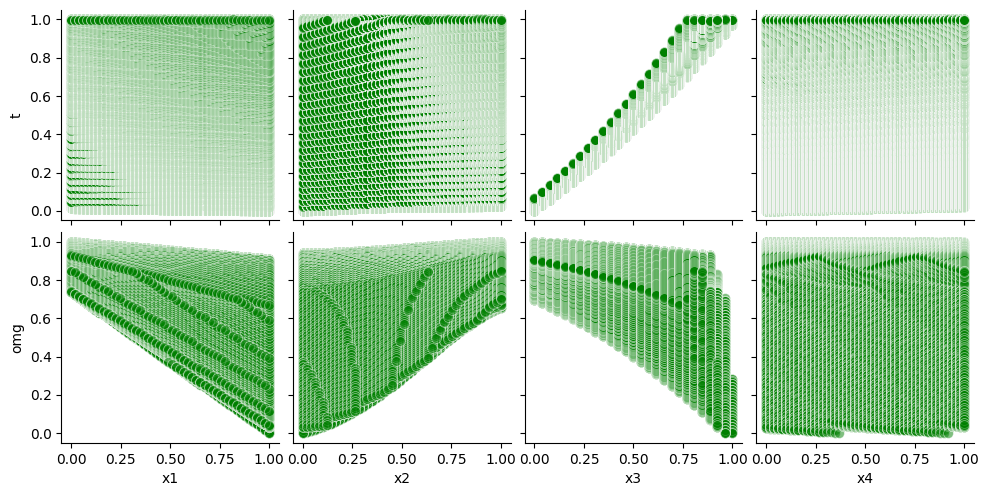

In [21]:
import pandas as pd
data = pd.DataFrame(np.hstack([X_scaled, Y_scaled]), columns=['x1', 'x2','x3','x4', 't', 'omg'])
sns.pairplot(data,diag_kind="kde",kind="scatter",x_vars=['x1', 'x2','x3','x4'],y_vars=['t', 'omg'],plot_kws=dict(s=50,edgecolor="w",color="g",alpha=.5))
plt.show()

模型训练

In [2]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from model.vae import CVAE
from model.simple import simple_mle
from src.utils import loss_fn
import torch.nn as nn

In [41]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
Y_tensor = torch.tensor(Y_scaled, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=4096, shuffle=True)

In [42]:
X_scaled.shape

(2942575, 4)

In [54]:
device = "cuda"

model = simple_mle().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [55]:
torch.cuda.is_available()

True

train

In [56]:
n_epochs = 10
for epoch in range(n_epochs):
    total_loss = 0
    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        x_pred = model(x_batch)
        loss = loss_fn(x_pred, y_batch)
        # x_recon, mu, logvar = model(x_batch, y_batch)
        # loss = loss_fn(x_recon, x_batch, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader):.4f}")


torch.save(model.state_dict(), "results/mle_model.pth")

Epoch 1: Loss = 0.0081
Epoch 2: Loss = 0.0000
Epoch 3: Loss = 0.0000
Epoch 4: Loss = 0.0000
Epoch 5: Loss = 0.0000
Epoch 6: Loss = 0.0000
Epoch 7: Loss = 0.0000
Epoch 8: Loss = 0.0000
Epoch 9: Loss = 0.0000
Epoch 10: Loss = 0.0000


sample

In [13]:
model_path = "results/mle_model.pth"
# model = CVAE()
model = simple_mle()
model.load_state_dict(torch.load(model_path))

from src.utils import gengrate_sample
from src.utils import gengrate_sample_mle
# samples_scaled = gengrate_sample_mle(model, cond=[y_scalers[0].transform(57.67),y_scalers[0].transform(-0.39)],num_samples=10,sample_std=10)
cond = np.asarray([57.67,-0.39]).reshape(-1,2)
cond_scaled = np.zeros(cond.shape)
for i in range(2):
    cond_scaled[:, i] = y_scalers[i].transform(cond[:, i].reshape(-1, 1)).flatten()
# samples_scaled = gengrate_sample(model, cond = cond_scaled.reshape(2,),num_samples=10,sample_std=1)
samples_scaled = gengrate_sample_mle(model, cond_scaled.reshape(2,),num_sample=10)

In [14]:
samples = np.zeros(samples_scaled.shape)
for i in range(4):
    samples[:, i] = x_scalers[i].inverse_transform(samples_scaled[:, i].reshape(-1, 1)).flatten()

In [16]:
samples

array([[0.00349435, 0.87724892, 2.0230596 , 0.00393879],
       [0.00343394, 0.87286919, 2.02980067, 0.00300028],
       [0.0034981 , 0.827937  , 2.02038599, 0.00414568],
       [0.0034186 , 0.75338688, 2.01941893, 0.00448165],
       [0.00327231, 0.81564951, 2.01759383, 0.00447518],
       [0.00331207, 0.96101849, 2.02110996, 0.0042827 ],
       [0.00346458, 0.79902806, 2.01007149, 0.00407291],
       [0.00348485, 0.91933877, 2.00535936, 0.00432958],
       [0.0027222 , 0.4869997 , 2.0277575 , 0.00437648],
       [0.00299338, 0.72530194, 2.02026716, 0.00401434]])

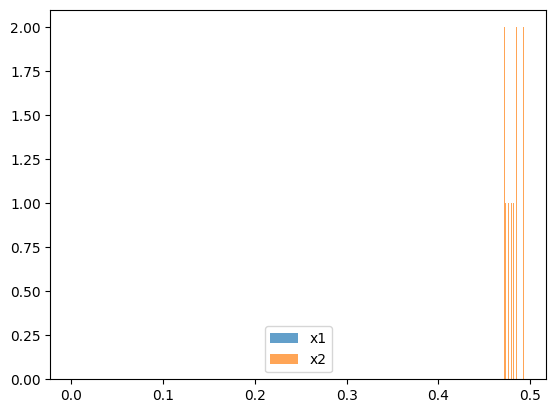

In [ ]:
plt.figure()
plt.hist(samples[:, 0], bins=20, alpha=0.7, label='x1')
plt.hist(samples[:, 1], bins=20, alpha=0.7, label='x2')
plt.legend()